## Loading Data, see the VIF to find Multicollinearity

In [6]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X_train = pd.read_csv('../data/X_train.csv')
y_train = pd.read_csv('../data/y_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv')

# Convert it to a Series for Statsmodels.
y_train = y_train.squeeze()
y_test = y_test.squeeze()


# List of reference categories to drop
# (We drop 'Bus' and 'Night' so they become the standard baseline)
# cols_to_drop = ['Vehicle_Bus', 'TimeOfDay_Night']


# X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
# X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

print("Reference categories dropped. Ready for VIF check or Modeling.")

# Create a VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
                   for i in range(len(X_train.columns))]

print(vif_data.sort_values(by="VIF", ascending=False))

Reference categories dropped. Ready for VIF check or Modeling.


c:\Users\win_10\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                feature       VIF
6         Vehicle_Train       inf
5         Vehicle_Plane       inf
4           Vehicle_Bus       inf
10      TimeOfDay_Night       inf
9     TimeOfDay_Morning       inf
8     TimeOfDay_Evening       inf
7   TimeOfDay_Afternoon       inf
2              LogPrice  2.329295
13           Route_Rate  2.242433
11            From_Rate  1.545958
12              To_Rate  1.524129
3           LogLeadTime  1.484006
1            TripReason  1.214839
0              Domestic  1.121596
14            User_Rate  1.020125


**Note**

At first, we deleted one column of our one hot encoder to see the multicolinearity of them and then we removed the variables with VIF>5
but now we are going to see the model's result with our clean data without deleting anythings

In [7]:
# # 1. Drop the redundant location parts (Keep only Route)
# cols_to_drop = ['From_Rate', 'To_Rate', 'Domestic','Route_Rate']

# # 2. Drop Price (Because it is highly collinear with Route + Vehicle)
# cols_to_drop.append('LogPrice')

# # Apply the drops
# X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
# X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

# # 3. Check VIF
# vif_data = pd.DataFrame()
# vif_data["feature"] = X_train.columns
# vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) 
#                    for i in range(len(X_train.columns))]

# print(vif_data.sort_values(by="VIF", ascending=False))

In [8]:

# === BASELINE MODEL: SIMPLE UNIVARIATE (LogLeadTime Only) ===
print("Target (y_train) shape:", y_train.shape)
print("y_train value counts:\n", y_train.value_counts())

# 1. PREPARE X_baseline (LogLeadTime Only)
X_baseline_train = X_train[['LogLeadTime']].copy()
X_baseline_train_const = sm.add_constant(X_baseline_train)

X_baseline_test = X_test[['LogLeadTime']].copy()
X_baseline_test_const = sm.add_constant(X_baseline_test)

# 2. FIT BASELINE MODEL (Logistic Regression via GLM)
baseline_model = sm.GLM(y_train, X_baseline_train_const, family=sm.families.Binomial()).fit()

# 3. RESULTS & INTERPRETATION
print("\n" + "="*70)
print("BASELINE MODEL: Logistic Regression (LogLeadTime Only)")
print("="*70)
print(baseline_model.summary())

# Model Performance Metrics
print(f"\nAIC (Akaike Information Criterion): {baseline_model.aic:.2f}")
print(f"BIC (Bayesian Information Criterion): {baseline_model.bic:.2f}")
print(f"Log-Likelihood: {baseline_model.llf:.2f}")

# Get predictions on test set
y_pred_prob = baseline_model.get_prediction(X_baseline_test_const).summary_frame()
print("\nTest Set Predictions (first 10 rows):")
print(y_pred_prob.head(10))


Target (y_train) shape: (79464,)
y_train value counts:
 Cancel
0    68553
1    10911
Name: count, dtype: int64

BASELINE MODEL: Logistic Regression (LogLeadTime Only)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Cancel   No. Observations:                79464
Model:                            GLM   Df Residuals:                    79462
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31116.
Date:                Mon, 26 Jan 2026   Deviance:                       62232.
Time:                        08:37:17   Pearson chi2:                 7.89e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01681
Covariance Type:            nonrobust                                         
                  coef    std err          

c:\Users\win_10\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [14]:

# === INTERPRETATION & MODEL EVALUATION ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

# 1. Extract coefficients
const = baseline_model.params['const']
lead_time_coef = baseline_model.params['LogLeadTime']

print("COEFFICIENT INTERPRETATION:")
print(f"  Intercept (β₀): {const:.4f}")
print(f"  LogLeadTime Coefficient (β₁): {lead_time_coef:.4f}")

# 2. Test Set Performance
y_pred_prob_values = baseline_model.get_prediction(X_baseline_test_const).summary_frame()['mean'].values
y_pred_binary = (y_pred_prob_values >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_prob_values)

print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print(f"\nConfusion Matrix:\n{cm}")
print(f"  TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"  FN: {cm[1,0]}, TP: {cm[1,1]}")


COEFFICIENT INTERPRETATION:
  Intercept (β₀): -2.4550
  LogLeadTime Coefficient (β₁): 0.3903

TEST SET PERFORMANCE
Accuracy:  0.8627
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.6111

Confusion Matrix:
[[17138     0]
 [ 2728     0]]
  TN: 17138, FP: 0
  FN: 2728, TP: 0


c:\Users\win_10\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Class Imbalance Problem & Solution

**Problem:** Our data has 13.7% positive class (cancellations) vs 86.3% negative (no cancellation).
- Model learns to predict 0 (non-cancellation) always → High accuracy, but useless!
- Precision/Recall become 0 because model never predicts 1.

**Solutions:**
**Oversampling (SMOTE)** - Create synthetic samples of minority class

In [15]:
# === OVERSAMPLING: SMOTE (Synthetic Minority Over-sampling Technique) ===
from imblearn.over_sampling import SMOTE

print("="*70)
print("STEP 1: APPLY SMOTE TO TRAINING DATA ONLY")
print("="*70)

print("\nBEFORE Oversampling (Training Data):")
print(f"Class 0 (No Cancel): {(y_train == 0).sum()} samples")
print(f"Class 1 (Cancel):    {(y_train == 1).sum()} samples")
print(f"Ratio: {(y_train == 1).sum() / len(y_train) * 100:.2f}% cancellations")

# Apply SMOTE ONLY to training data
# SMOTE creates synthetic samples of the minority class (1) to match majority class (0)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAFTER Oversampling (Training Data):")
print(f"Class 0 (No Cancel): {(y_train_balanced == 0).sum()} samples")
print(f"Class 1 (Cancel):    {(y_train_balanced == 1).sum()} samples")
print(f"Ratio: {(y_train_balanced == 1).sum() / len(y_train_balanced) * 100:.2f}% cancellations")

# Prepare balanced baseline data (LogLeadTime only)
X_baseline_train_balanced = X_train_balanced[['LogLeadTime']].copy()
X_baseline_train_balanced_const = sm.add_constant(X_baseline_train_balanced)

print("\n" + "="*70)
print("STEP 2: FIT BASELINE MODEL WITH BALANCED DATA")
print("="*70)

# Fit model on balanced training data
baseline_model_balanced = sm.GLM(y_train_balanced, X_baseline_train_balanced_const, 
                                  family=sm.families.Binomial()).fit()

print(baseline_model_balanced.summary())

print(f"\nAIC: {baseline_model_balanced.aic:.2f}")
print(f"Log-Likelihood: {baseline_model_balanced.llf:.2f}")

# Predictions on TEST set (still using original unbalanced test data)
y_pred_prob_balanced = baseline_model_balanced.get_prediction(X_baseline_test_const).summary_frame()['mean'].values

print("\nTest Set Prediction Distribution:")
print(f"  Min: {y_pred_prob_balanced.min():.4f}")
print(f"  Max: {y_pred_prob_balanced.max():.4f}")
print(f"  Mean: {y_pred_prob_balanced.mean():.4f}")
print(f"  Median: {np.median(y_pred_prob_balanced):.4f}")

STEP 1: APPLY SMOTE TO TRAINING DATA ONLY

BEFORE Oversampling (Training Data):
Class 0 (No Cancel): 68553 samples
Class 1 (Cancel):    10911 samples
Ratio: 13.73% cancellations

AFTER Oversampling (Training Data):
Class 0 (No Cancel): 68553 samples
Class 1 (Cancel):    68553 samples
Ratio: 50.00% cancellations

STEP 2: FIT BASELINE MODEL WITH BALANCED DATA
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Cancel   No. Observations:               137106
Model:                            GLM   Df Residuals:                   137104
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -92413.
Date:                Mon, 26 Jan 2026   Deviance:                   1.8483e+05
Time:                        08:42:40   Pearson chi2:                 1.37e+05
No. Iter


STEP 3: FIND OPTIMAL PROBABILITY THRESHOLD


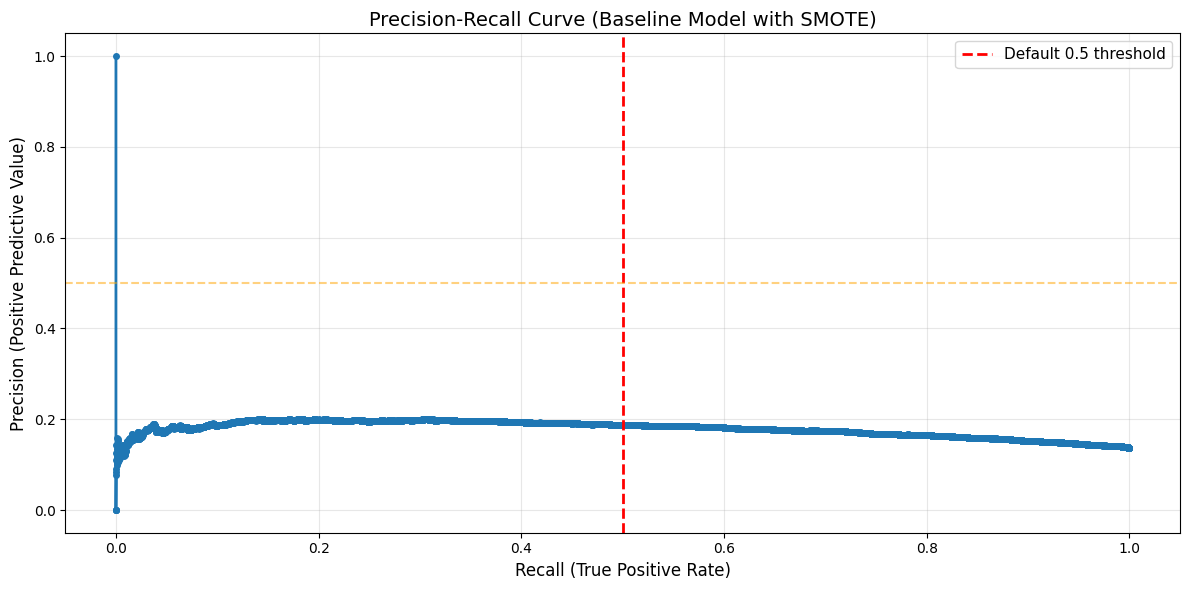

----------------------------------------------------------------------

✓ Optimal Threshold: 0.45 (Best F1-Score: 0.2791)

BASELINE MODEL PERFORMANCE (Threshold = 0.45)
Accuracy:  0.4896
Precision: 0.1731
Recall:    0.7196
F1-Score:  0.2791
ROC-AUC:   0.6111

Confusion Matrix (with optimal threshold):
  TN: 7763, FP: 9375
  FN: 765, TP: 1963


In [16]:
# === STEP 3: FIND OPTIMAL THRESHOLD ===
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

print("\n" + "="*70)
print("STEP 3: FIND OPTIMAL PROBABILITY THRESHOLD")
print("="*70)

# Find optimal threshold using Precision-Recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob_balanced)

# Plot P-R curve
plt.figure(figsize=(12, 6))
plt.plot(recalls, precisions, marker='o', linewidth=2, markersize=4)
plt.xlabel('Recall (True Positive Rate)', fontsize=12)
plt.ylabel('Precision (Positive Predictive Value)', fontsize=12)
plt.title('Precision-Recall Curve (Baseline Model with SMOTE)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axvline(x=0.5, color='r', linestyle='--', label='Default 0.5 threshold', linewidth=2)
plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.5)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

best_f1 = 0
best_threshold = 0.5

for threshold in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    y_pred_thresh = (y_pred_prob_balanced >= threshold).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1_t = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    if f1_t > best_f1:
        best_f1 = f1_t
        best_threshold = threshold
    

print("-"*70)
print(f"\n✓ Optimal Threshold: {best_threshold:.2f} (Best F1-Score: {best_f1:.4f})")

# Use optimal threshold for final evaluation
y_pred_final = (y_pred_prob_balanced >= best_threshold).astype(int)

print("\n" + "="*70)
print(f"BASELINE MODEL PERFORMANCE (Threshold = {best_threshold:.2f})")
print("="*70)

accuracy_final = accuracy_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final, zero_division=0)
recall_final = recall_score(y_test, y_pred_final, zero_division=0)
f1_final = f1_score(y_test, y_pred_final, zero_division=0)
roc_auc_final = roc_auc_score(y_test, y_pred_prob_balanced)

print(f"Accuracy:  {accuracy_final:.4f}")
print(f"Precision: {precision_final:.4f}")
print(f"Recall:    {recall_final:.4f}")
print(f"F1-Score:  {f1_final:.4f}")
print(f"ROC-AUC:   {roc_auc_final:.4f}")

# Final confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
print(f"\nConfusion Matrix (with optimal threshold):")
print(f"  TN: {cm_final[0,0]}, FP: {cm_final[0,1]}")
print(f"  FN: {cm_final[1,0]}, TP: {cm_final[1,1]}")

In [17]:
# === STEP 4: FULL MODEL WITH ALL FEATURES (BALANCED DATA) ===
from scipy import stats
from sklearn.metrics import log_loss, mean_squared_error

print("\n" + "="*70)
print("STEP 4: FULL MODEL - ALL FEATURES WITH BALANCED DATA")
print("="*70)

# Prepare balanced full data (all cleaned features)
# X_full_train_balanced = X_train_balanced.drop(columns=['From_Rate', 'To_Rate', 'Domestic', 'LogPrice'], 
#                                                errors='ignore').copy()
X_full_train_balanced_const = sm.add_constant(X_train_balanced)

# X_full_test = X_test.drop(columns=['From_Rate', 'To_Rate', 'Domestic', 'LogPrice'], 
                        #   errors='ignore').copy()
X_full_test_const = sm.add_constant(X_test)

# Fit full model on balanced training data
full_model_balanced = sm.GLM(y_train_balanced, X_full_train_balanced_const, 
                              family=sm.families.Binomial()).fit()

print(full_model_balanced.summary())

# Get predictions from full model
y_pred_prob_full = full_model_balanced.get_prediction(X_full_test_const).summary_frame()['mean'].values

print("\n" + "="*70)
print("MODEL COMPARISON: BASELINE vs FULL MODEL")
print("="*70)

# Cross-Entropy Loss (Log Loss) - measure of how well probabilities match actual labels
baseline_cross_entropy = log_loss(y_test, y_pred_prob_balanced)
full_cross_entropy = log_loss(y_test, y_pred_prob_full)


# Create comparison dataframe
comparison_data = {
    'Metric': ['AIC', 'BIC', 'Log-Likelihood', 'Cross-Entropy Loss', 'Features Used'],
    'Baseline (LogLeadTime)': [
        f"{baseline_model_balanced.aic:.2f}",
        f"{baseline_model_balanced.bic:.2f}",
        f"{baseline_model_balanced.llf:.2f}",
        f"{baseline_cross_entropy:.4f}",
        "1"
    ],
    'Full Model (All)': [
        f"{full_model_balanced.aic:.2f}",
        f"{full_model_balanced.bic:.2f}",
        f"{full_model_balanced.llf:.2f}",
        f"{full_cross_entropy:.4f}",
        f"{len(X_train_balanced.columns)}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Likelihood Ratio Test (Statistical Significance)
lr_stat = 2 * (full_model_balanced.llf - baseline_model_balanced.llf)
num_extra_features = len(X_train_balanced.columns) - 1
lr_pvalue = 1 - stats.chi2.cdf(lr_stat, df=num_extra_features)


# Find optimal threshold for full model too
precisions_full, recalls_full, thresholds_full = precision_recall_curve(y_test, y_pred_prob_full)

# Simple approach: test same threshold on full model
y_pred_full_final = (y_pred_prob_full >= best_threshold).astype(int)

print(f"\nUsing threshold = {best_threshold:.2f}:\n")
print(f"{'Metric':<15} {'Baseline':<15} {'Full Model':<15}")
print("-"*45)

baseline_acc = accuracy_score(y_test, y_pred_final)
full_acc = accuracy_score(y_test, y_pred_full_final)
print(f"{'Accuracy':<15} {baseline_acc:<15.4f} {full_acc:<15.4f}")

baseline_prec = precision_score(y_test, y_pred_final, zero_division=0)
full_prec = precision_score(y_test, y_pred_full_final, zero_division=0)
print(f"{'Precision':<15} {baseline_prec:<15.4f} {full_prec:<15.4f}")

baseline_rec = recall_score(y_test, y_pred_final, zero_division=0)
full_rec = recall_score(y_test, y_pred_full_final, zero_division=0)
print(f"{'Recall':<15} {baseline_rec:<15.4f} {full_rec:<15.4f}")

baseline_f1 = f1_score(y_test, y_pred_final, zero_division=0)
full_f1 = f1_score(y_test, y_pred_full_final, zero_division=0)
print(f"{'F1-Score':<15} {baseline_f1:<15.4f} {full_f1:<15.4f}")

baseline_auc = roc_auc_score(y_test, y_pred_prob_balanced)
full_auc = roc_auc_score(y_test, y_pred_prob_full)
print(f"{'ROC-AUC':<15} {baseline_auc:<15.4f} {full_auc:<15.4f}")


STEP 4: FULL MODEL - ALL FEATURES WITH BALANCED DATA
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Cancel   No. Observations:               137106
Model:                            GLM   Df Residuals:                   137090
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -88704.
Date:                Mon, 26 Jan 2026   Deviance:                   1.7741e+05
Time:                        08:49:47   Pearson chi2:                 1.37e+05
No. Iterations:                    22   Pseudo R-squ. (CS):            0.08821
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

c:\Users\win_10\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [19]:
# === STEP 5: FEATURE IMPORTANCE & COEFFICIENT INTERPRETATION ===

print("\n" + "="*70)
print("STEP 5: FEATURE IMPORTANCE (Odds Ratios)")
print("="*70)

# Extract full model coefficients and calculate odds ratios
coef_summary = pd.DataFrame({
    'Feature': X_full_train_balanced_const.columns,
    'Coefficient': full_model_balanced.params.values,
    'Std Error': full_model_balanced.bse.values,
    'P-value': full_model_balanced.pvalues.values
})

# Calculate Odds Ratio = exp(coefficient)
coef_summary['Odds Ratio'] = np.exp(coef_summary['Coefficient'])
coef_summary['OR Interpretation'] = coef_summary['Odds Ratio'].apply(
    lambda x: f"{'↑' if x > 1 else '↓'} {abs((x-1)*100):.1f}%" if x != 1 else "No effect"
)

# Sort by absolute coefficient value
coef_summary['Abs_Coef'] = abs(coef_summary['Coefficient'])
coef_summary_sorted = coef_summary.sort_values('Abs_Coef', ascending=False).drop('Abs_Coef', axis=1)

print(coef_summary_sorted.to_string(index=False))


# Show which features are significant
print("\nSignificant Features (p < 0.05):")
significant = coef_summary_sorted[coef_summary_sorted['P-value'] < 0.05]
if len(significant) > 0: 
    for idx, row in significant[0:].iterrows(): 
        effect = "INCREASES" if row['Coefficient'] > 0 else "DECREASES"
        print(f"  ✓ {row['Feature']:30} → {effect:10} (p={row['P-value']:.4f})")
else:
    print("  Only intercept is significant - features may need re-scaling")

print("\nInsignificant Features (p ≥ 0.05):")
insignificant = coef_summary_sorted[coef_summary_sorted['P-value'] >= 0.05]
for idx, row in insignificant[0:].iterrows():  
    print(f"  ✗ {row['Feature']:30} (p={row['P-value']:.4f})")



STEP 5: FEATURE IMPORTANCE (Odds Ratios)
            Feature  Coefficient    Std Error       P-value   Odds Ratio           OR Interpretation
              const    44.028186 26604.466605  9.986796e-01 1.321899e+19 ↑ 1321899226860688244736.0%
      Vehicle_Plane   -24.175237 21475.511631  9.991018e-01 3.168313e-11                    ↓ 100.0%
  TimeOfDay_Evening   -24.047383 15703.504177  9.987782e-01 3.600427e-11                    ↓ 100.0%
TimeOfDay_Afternoon   -23.977190 15703.504177  9.987817e-01 3.862234e-11                    ↓ 100.0%
  TimeOfDay_Morning   -23.972697 15703.504177  9.987820e-01 3.879628e-11                    ↓ 100.0%
    TimeOfDay_Night   -23.916498 15703.504177  9.987848e-01 4.103903e-11                    ↓ 100.0%
      Vehicle_Train   -23.808876 21475.511631  9.991154e-01 4.570212e-11                    ↓ 100.0%
        Vehicle_Bus   -23.623516 21475.511631  9.991223e-01 5.500948e-11                    ↓ 100.0%
         Route_Rate     6.712095     0.208000 1.8